### This is a Tutorial Notebook to view CTO Labels
- Prequisites:
    - Navigate to https://zenodo.org/doi/10.5281/zenodo.11535960 (this link always resolves to the latest version), and download the latest version of CTO! 
    I downloaded the v0.3 labeling.zip, and placed it in the parent directory.
        ```bash
        wget https://zenodo.org/records/11608615/files/labeling.zip -P ../
        ```
    - Go to https://aact.ctti-clinicaltrials.org/download and download the latest version of the pipe-delimited files, and extract it in the parent folders as ../CTTI/ 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

studies_df = pd.read_csv('../CTTI/studies.txt', sep='|')
intervention_df = pd.read_csv('../CTTI/interventions.txt', sep='|')
intervention_df = intervention_df[intervention_df['intervention_type']=='Drug']

studies_df = studies_df[studies_df['overall_status']=='Completed']
studies_df = studies_df[studies_df['nct_id'].isin(intervention_df['nct_id'])]
print(studies_df.shape)

with zipfile.ZipFile('../labeling.zip', 'r') as zip_ref:
    # print(zip_ref.namelist())
    # print([_ for _ in zip_ref.namelist() if 'weak_preds_on_all' in _])
    # phase1_df = pd.read_csv(zip_ref.open('labeling/weak_preds_on_all/phase1_dp.csv'))
    # phase2_df = pd.read_csv(zip_ref.open('labeling/weak_preds_on_all/phase2_dp.csv'))
    phase3_df = pd.read_csv(zip_ref.open('labeling/weak_preds_on_all/phase3_dp.csv'))
phase3_df = phase3_df.iloc[:,[0,1,4,6,8,10,11,12,13,14,15,16,17,18,19,20,21,22]] # deduplicate LFs used in data programming
phase3_df = phase3_df[phase3_df['nct_id'].isin(studies_df['nct_id'])]
phase3_df = phase3_df.iloc[:,1:-1]
print(phase3_df.shape)

/tmp/ipykernel_1602685/244987547.py:7: DtypeWarning: Columns (46,47,48,53,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  studies_df = pd.read_csv('../CTTI/studies.txt', sep='|')


(103190, 70)
(108441, 16)


In [6]:
phase3_df.columns

Index(['hint', ' status', ' gpt', ' linkage', ' stock_price',
       ' results_reported', 'update_more_recent', 'sites', 'serious_ae',
       'pvalues', 'patient_drop', 'num_patients', 'news_headlines', 'death_ae',
       'amendments', 'all_ae'],
      dtype='object')

<Axes: title={'center': 'Kappa of Data Programming Labels (Calibrated on TOP Phase 3)'}>

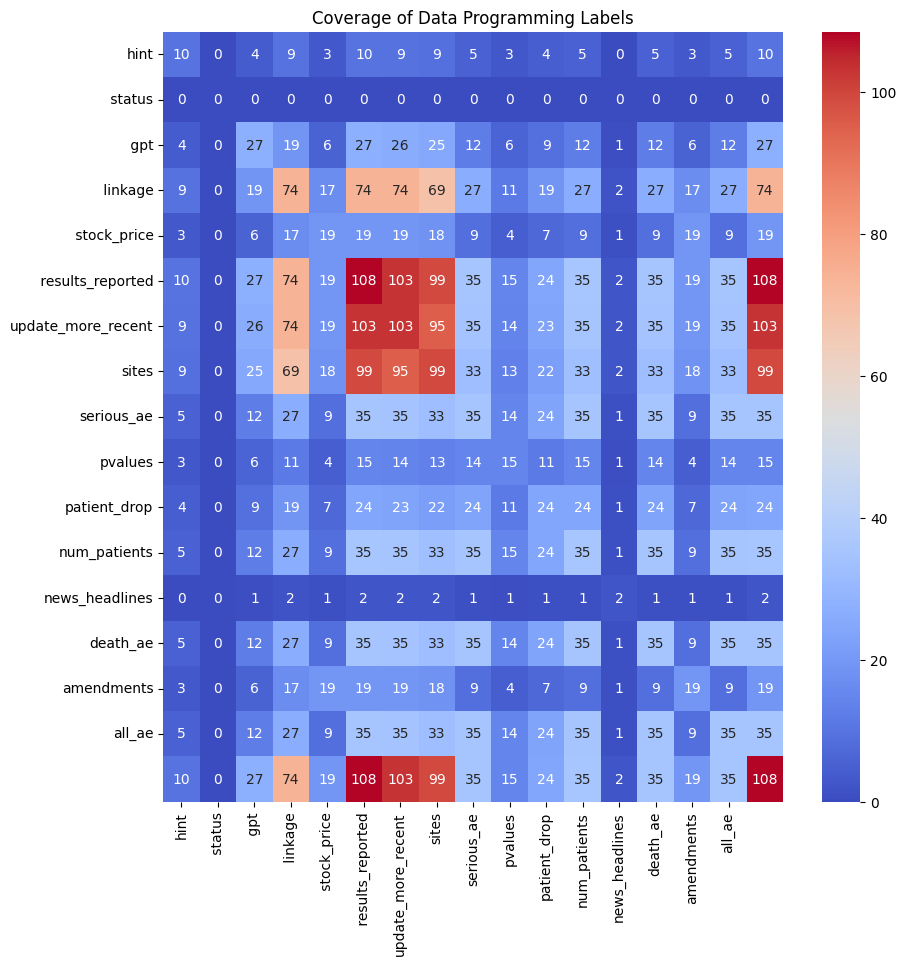

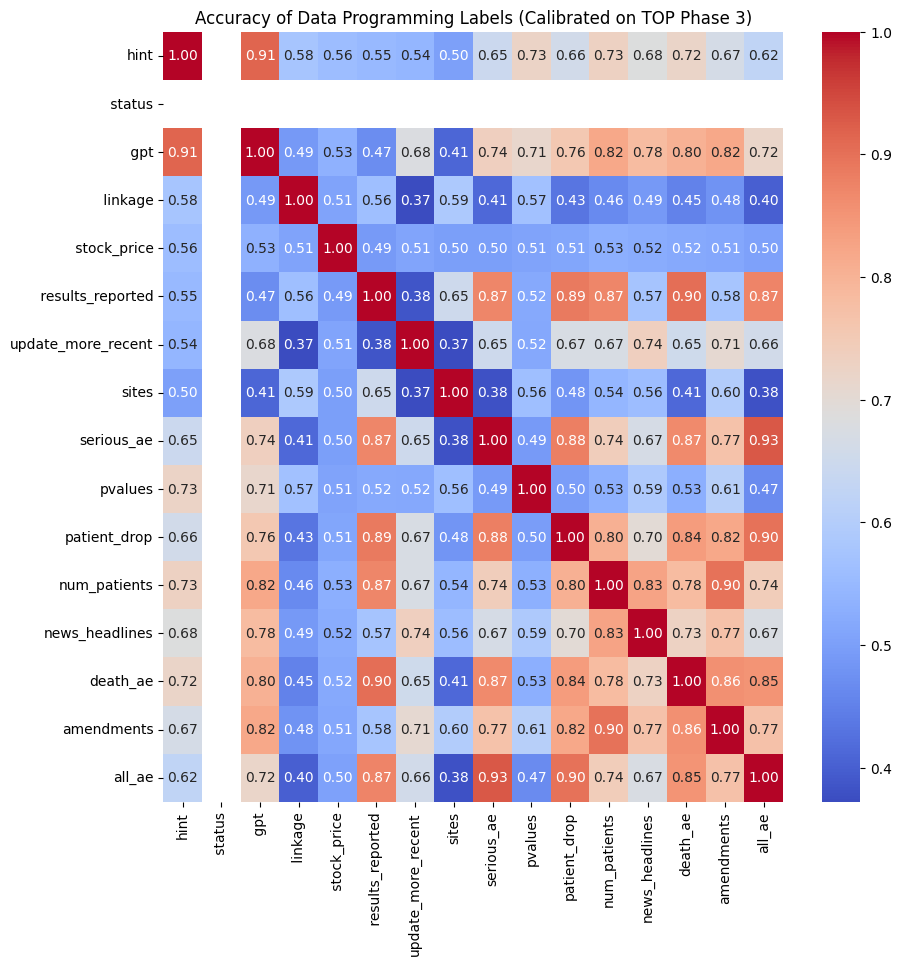

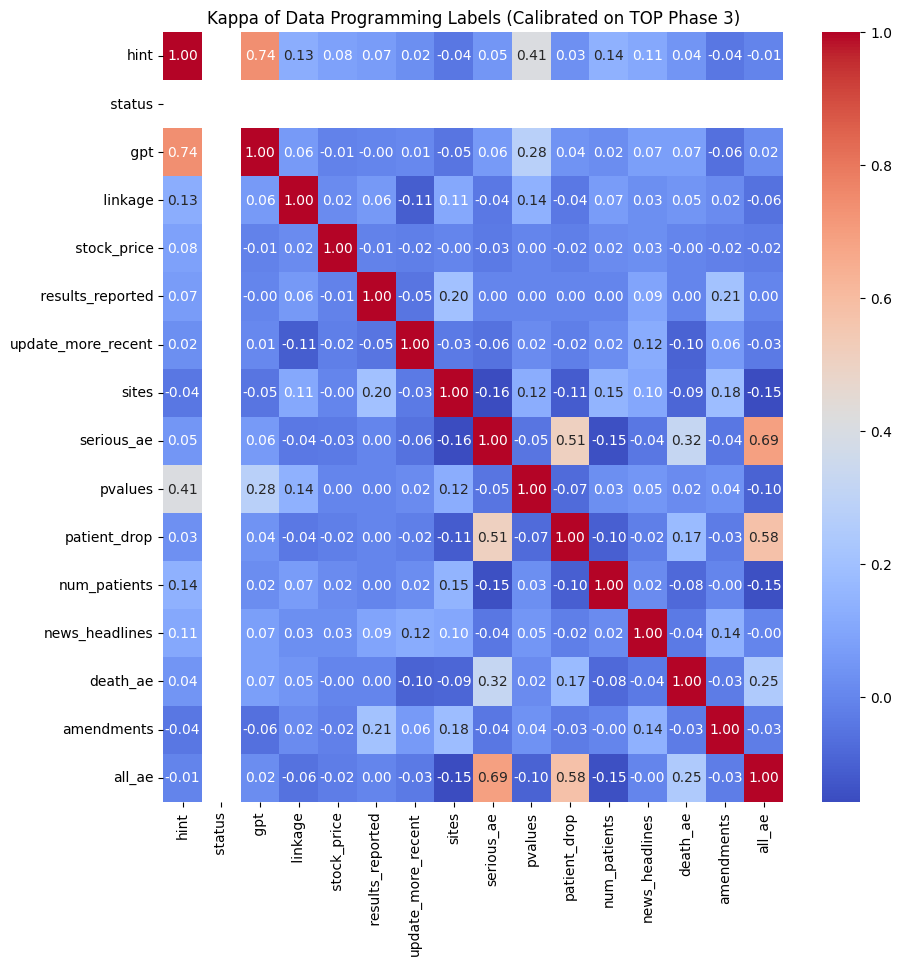

In [7]:
from sklearn.metrics import cohen_kappa_score, accuracy_score
# plot heatmap of coverage, i.e. when both are 1
def joint_coverage(df):
    # returns fraction of all column combinations that are 1
    coverage = np.zeros((df.shape[1], df.shape[1]))
    for i in range(df.shape[1]):
        for j in range(df.shape[1]):
            coverage[i,j] = (df.iloc[:,i] & df.iloc[:,j]).sum() / 1000
    return coverage

def accuracy_agreement(df, mode='accuracy'):
    # return pairwise cohen kappa agreement
    kappa = np.zeros((df.shape[1], df.shape[1]))
    for i in range(df.shape[1]):
        for j in range(df.shape[1]):
            # only compute kappa score if both is not -1
            mask = np.where((df.iloc[:,i] != -1) & (df.iloc[:,j] != -1))[0]
            if mask.sum() > 0:
                if mode == 'accuracy':
                    kappa[i,j] = accuracy_score(y_true=df.iloc[mask,i], y_pred=df.iloc[mask,j])
                elif mode == 'kappa':
                    kappa[i,j] = cohen_kappa_score(df.iloc[mask,i], df.iloc[mask,j])
            else:
                kappa[i,j] = np.nan
    return kappa

phase3_df_coverage = phase3_df.astype(int)!=-1
phase3_df_coverage['all_ncts'] = 1

coverage = joint_coverage(phase3_df_coverage)
# totate coverage matrix text
plt.figure(figsize=(10,10))
plt.title('Coverage of Data Programming Labels')
sns.heatmap(coverage, cmap='coolwarm', annot=True, fmt=".0f", 
            xticklabels=phase3_df.columns, 
            yticklabels=phase3_df.columns)

plt.figure(figsize=(10,10))
plt.title('Accuracy of Data Programming Labels (Calibrated on TOP Phase 3)')
kappa = accuracy_agreement(phase3_df, mode='accuracy')
sns.heatmap(kappa, cmap='coolwarm', annot=True, fmt=".2f", 
            xticklabels=phase3_df.columns, 
            yticklabels=phase3_df.columns)

plt.figure(figsize=(10,10))
plt.title('Kappa of Data Programming Labels (Calibrated on TOP Phase 3)')
kappa = accuracy_agreement(phase3_df, mode='kappa')
sns.heatmap(kappa, cmap='coolwarm', annot=True, fmt=".2f", 
            xticklabels=phase3_df.columns, 
            yticklabels=phase3_df.columns)

<Axes: title={'center': 'Coverage of Data Programming Labels (Subset)'}>

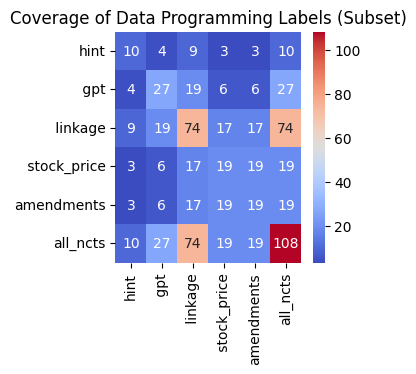

In [8]:
plt.figure(figsize=(3,3))
plt.title('Coverage of Data Programming Labels (Subset)')
subset_cols = ['hint', ' gpt', ' linkage', ' stock_price', 'amendments', 'all_ncts']
coverage = joint_coverage(phase3_df_coverage[subset_cols])
sns.heatmap(coverage, cmap='coolwarm', annot=True, fmt=".0f", 
            xticklabels=subset_cols, 
            yticklabels=subset_cols)
